In [1]:
import sys
sys.path.append('../..')
import datetime

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

confirmed_cases = cov19.get_jhu_confirmed_cases()

date_data_begin = datetime.datetime(2020,3,1)
# date_data_end   = cov19.get_last_date(confirmed_cases)
date_data_end = datetime.datetime(2020,4,24)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 12 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 21
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days

country = 'Germany'

cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_median_lambda = 1,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.5,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.25,
                      pr_sigma_lambda = 1)]

model_rw = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                   N=83e6,
                                   priors_dict=dict(pr_sigma_random_walk=0.1,
                                                    pr_sigma_lambda_0=1,
                                                    pr_median_lambda_0=2),
                                   with_random_walk=True)


model_not_rw = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                   N=83e6,
                                   priors_dict=None,
                                   with_random_walk=False)

trace_rw = pm.sample(model=model_rw, init='advi', draws=3000)
trace_not_rw = pm.sample(model=model_not_rw, init='advi', draws=3000)
# advi is important as initialization, other initializations methods lead
# to more divergences
path_to_save = '../../figures/'

INFO: This code is not longer developed, use our new module instead: github.com/Priesemann-Group/covid19_inference
pr_beta_I_begin was set to default value 100
pr_beta_E_begin_scale was set to default value 10
pr_median_mu was set to default value 0.3333333333333333
pr_sigma_mu was set to default value 0.3
pr_median_delay was set to default value 5
pr_sigma_delay was set to default value 0.2
scale_delay was set to default value 0.3
pr_beta_sigma_obs was set to default value 10
pr_mean_median_incubation was set to default value 5
pr_sigma_median_incubation was set to default value 1
sigma_incubation was set to default value 0.418
pr_sigma_date_begin_transient of change point 0 was set to default value 3
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_len of change point 2 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3
pr_sigma_tr

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 544.39:   8%|▊         | 16290/200000 [02:47<31:24, 97.46it/s] 
Convergence achieved at 16300
Interrupted at 16,299 [8%]: Average Loss = 1,862.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [median_incubation, sigma_obs, delay, mu, lambda_t_random_walk, sigma_random_walk, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, lambda_3, lambda_2, lambda_1, lambda_0, E_begin, E_begin_scale, I_begin]
Sampling 4 chains, 1 divergences: 100%|██████████| 14000/14000 [5:15:28<00:00,  1.35s/draws]  
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6586327148955489, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9246908853469996, but should be close to 0.8. T

In [4]:
exec(open('figures_revised.py').read())

additional insets: E_begin_scale
additional insets: median_incubation


/Users/paul/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2013: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


(<Figure size 288x432 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2f6d6e50>,
       dtype=object))

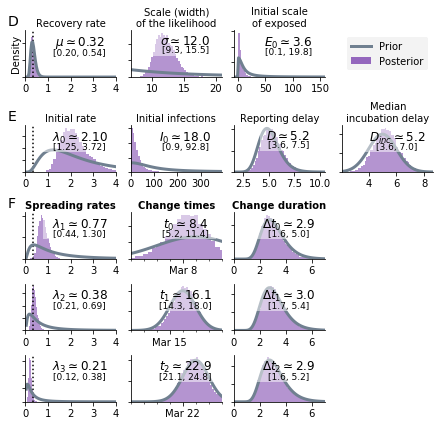

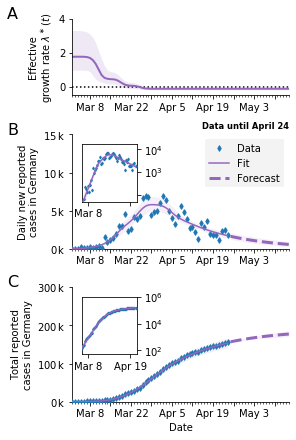

In [6]:
create_figure_distributions(model_not_rw, trace_not_rw,
                              additional_insets = {'E_begin_scale': r"$E_0 \simeq ",
                                                   'median_incubation': r"$D_{inc} \simeq "}, 
                              xlim_lambda = (0, 4), color = 'tab:purple',
                              num_changepoints=3, save_to=path_to_save + 'Fig_SEIR_not_rw_distr')
create_figure_timeseries(trace_not_rw, 'tab:purple', num_days_futu_to_plot=21, y_lim_lambda = (-0.5, 4),
                       plot_red_axis=False, save_to=path_to_save + 'Fig_SEIR_not_rw_cases')

additional insets: E_begin_scale
additional insets: median_incubation
additional insets: sigma_random_walk


/Users/paul/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2013: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


(<Figure size 288x432 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a321993d0>,
       dtype=object))

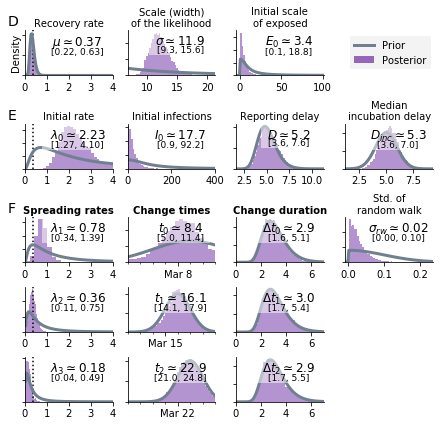

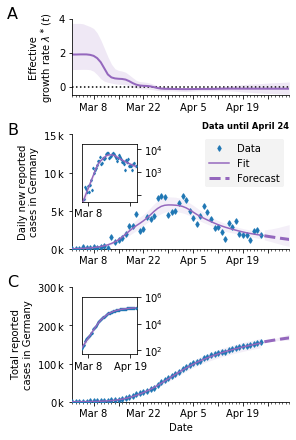

In [7]:
create_figure_distributions(model_rw, trace_rw,
                              additional_insets = {'E_begin_scale': r"$E_0 \simeq ",
                                                   'median_incubation': r"$D_{inc} \simeq ",
                                                   'sigma_random_walk': r"$\sigma_{rw} \simeq "}, 
                              xlim_lambda = (0, 4), color = 'tab:purple',
                              num_changepoints=3, save_to=path_to_save + 'Fig_SEIR_rw_distr')
create_figure_timeseries(trace_rw, 'tab:purple', num_days_futu_to_plot=8, y_lim_lambda = (-0.5, 4),
                       plot_red_axis=False, save_to=path_to_save + 'Fig_SEIR_rw_cases')

In [ ]:
print("With random walk \n")
print(pm.loo(trace_rw, model_rw))
print("Without random walk \n")
print(pm.loo(trace_not_rw, model_not_rw))